In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [47]:
# Initialize a single 2-variate Gaussian.
mu = [0, 0]
cov = [[ 1,  0.9],
       [ 0.9,  1]]
cov = np.array(cov, dtype=np.float32)
scale = tf.linalg.cholesky(cov)
print(scale)
mvn = tfd.MultivariateNormalTriL(
    loc=mu,
    scale_tril=scale)


tf.Tensor(
[[1.         0.        ]
 [0.9        0.43588996]], shape=(2, 2), dtype=float32)


In [48]:
mvn

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

In [49]:
mvn.log_prob([0,0])

<tf.Tensor: shape=(), dtype=float32, numpy=-1.0075116>

In [50]:
mvn.log_prob([1,0])

<tf.Tensor: shape=(), dtype=float32, numpy=-3.6390903>

In [51]:
mvn.log_prob([xr[0],xr[0]])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-53.63909, -53.63909], dtype=float32)>

In [52]:
log_prob = mvn.log_prob

(100, 1)


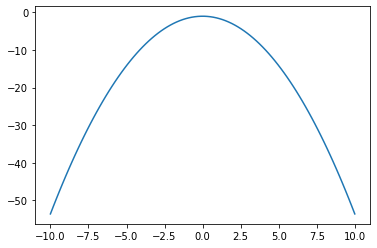

In [53]:
xr = tf.convert_to_tensor(np.linspace(-10, 10, 100), dtype=tf.float32)
xr = xr[:,tf.newaxis]
print(xr.shape)
plt.figure()
plt.plot(xr, mvn.log_prob(xr))

In [296]:
@tf.function(experimental_compile=True)
# @tf.function
def metropolis_hastings(log_prob, proposal_cov, iters, init, dtype=tf.float32):
    """Metropolis-Hastings: adapted from colindcarroll
    """
    dim = proposal_cov.shape[0]
    
    # TensorArray 
    samples = tf.TensorArray(dtype=dtype, size=iters, clear_after_read=False)
    
    sample = tf.cast(init, tf.float32)
    samples = samples.write(0, sample)
    
    current_log_prob = log_prob(sample)
    
    scale = tf.linalg.cholesky(cov)
    proposals_dist = tfd.MultivariateNormalTriL(loc=tf.zeros(dim, dtype=dtype), scale_tril=scale)
    proposals = proposals_dist.sample(iters-1)
    
    log_unifs = tf.math.log(tf.random.uniform([iters-1], dtype=dtype))
    
    for idx in tf.range(1, iters-1):
        log_unif = log_unifs[idx]
        sample = proposals[idx]
        proposal = sample + samples.read(idx-1)
        proposal_log_prob = log_prob(proposal)
        
        # accept is False (zero) or True (one)
        accept = (log_unif < proposal_log_prob - current_log_prob)
        
        if accept:
            proposal = tf.cast(proposal, tf.float32)
        else:
            proposal = samples.read(idx-1)
            
        samples = samples.write(idx, proposal)
            
        current_log_prob = proposal_log_prob
    
    return samples.stack()

In [284]:
%%time
samples = metropolis_hastings(log_prob, cov, 1000, [0,0])

CPU times: user 484 ms, sys: 23.6 ms, total: 507 ms
Wall time: 472 ms


In [268]:
%%time
samples = metropolis_hastings(log_prob, cov, 1000, [0,0])

CPU times: user 3.53 s, sys: 12 ms, total: 3.54 s
Wall time: 3.55 s


In [297]:
%%time
samples = metropolis_hastings(log_prob, cov, 10000, [0,0])

CPU times: user 847 ms, sys: 9.08 ms, total: 856 ms
Wall time: 857 ms


In [298]:
samples

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.       ,  0.       ],
       [-1.1400731, -1.4667404],
       [-1.1400731, -1.4667404],
       ...,
       [ 2.7550864,  2.1620722],
       [ 2.8103049,  2.170106 ],
       [ 0.       ,  0.       ]], dtype=float32)>

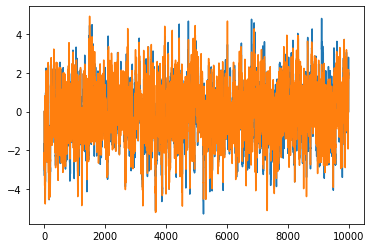

In [299]:
plt.figure()
plt.plot(samples[:,0])
plt.plot(samples[:,1])

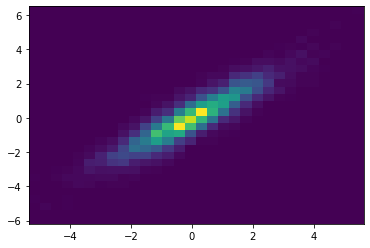

In [290]:
plt.figure()
plt.hist2d(samples[:,0], samples[:,1], bins=30);

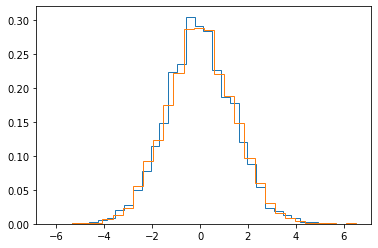

In [291]:
plt.figure()
plt.hist(samples[:,0], histtype='step', bins=30, density=True);
plt.hist(samples[:,1], histtype='step', bins=30, density=True);